In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
# Install OpenPose

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

In [0]:
# delete directory
filename = '/content/drive/My Drive/Colab Notebooks/ANN/test_openpose/'

if os.path.exists(filename):
    os.rmdir(filename)

In [25]:
# get body landmarks using open pose
!cd openpose && ./build/examples/openpose/openpose.bin --video /content/drive/My\ Drive/Colab\ Notebooks/ANN/11/test5.mp4 --write_json /content/drive/My\ Drive/Colab\ Notebooks/ANN/test_openpose1/ --display 0 --render_pose 0

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 27.068344 seconds.


In [3]:
path = '/scratch/user/mahin/ANN/test/'
model = load_model('/scratch/user/mahin/ANN/model5.h5')

def test_prepare_data(file_name, path):
    d = list()
    for file in os.listdir(path):
        if file.startswith(file_name + '_'):
            with open(os.path.join(path, file)) as f_json:
                df = json.load(f_json)
                if (df['people'] != []):
                    keypoints = df['people'][0]['pose_keypoints_2d']
                    d.append(keypoints)
    return d

def testing(file_name, n_sec):
    test = np.array(test_prepare_data(file_name, path))
    X_test = np.array(test)
    print("X_test shape = %s"%(str(X_test.shape)))
    y_hat = model.predict(X_test)
    print("y_hat shape = %s"%(str(y_hat.shape)))

    frame_per_sec = int(np.ceil(y_hat.shape[0] / n_sec))
    print(frame_per_sec)
    arr1 = y_hat[0:(n_sec - 1) * frame_per_sec]
    arr2 = y_hat[(n_sec - 1) * frame_per_sec:]
    arr1 = arr1.reshape(n_sec - 1, frame_per_sec)
    
    th = 0.8
    th2 = 0.7
    y_hat_class = np.zeros(n_sec)
    for m in range(arr1.shape[0]):
        a = arr1[m]
        aa = a[a > th]
        aaa = a[a > th2]    
        if aa.shape[0] >= (frame_per_sec * 0.2):
            y_hat_class[m] = np.mean(a[a > 0.5])
        elif aaa.shape[0] >= (frame_per_sec * 0.7):
            y_hat_class[m] = np.mean(a[a > 0.5])
            
        if(m == arr1.shape[0] - 1):
            a = arr2
            aa = a[a > th]
            aaa = a[a > th2]    
            if aa.shape[0] >= (arr2.shape[0] * 0.25):
                y_hat_class[m + 1] = np.mean(a[a > 0.5])
            elif aaa.shape[0] >= (arr2.shape[0] * 0.8):
                y_hat_class[m + 1] = np.mean(a[a > 0.5])
    
    # show the figure
    sec = range(0, n_sec)
    plt.plot(sec, y_hat_class, 'b') #################
    plt.ylabel('Label')
    plt.xlabel('time')
    plt.ylim([-0.1 , 1.1])
    plt.legend()

    # create json file
    y_j = 0
    p_list = []
    for i in range(len(y_hat_class)):
        if y_hat_class[i] > 0:
            y_j += 1
            prob = 0
            n = 0
            if i != len(y_hat_class) - 1:
                for j in (arr1[i]):
                    if j > th2:
                        prob = prob + j
                        n = n + 1
            else:
                for j in (arr2):
                    if j > th2:
                        prob = prob + j
                        n = n + 1
            prob = prob / n
            p_list.append([i, float(prob)])
            
    if (y_j > 0): 
        j_dict = {"pick up": p_list}
    else:
        j_dict = {"pick up": [0, float(y_hat[0])] }

    print(j_dict)
    return j_dict


/scratch/user/mahin/.conda/envs/my_env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


X_test shape = (4190, 75)


No handles with labels found to put in legend.


y_hat shape = (4190, 1)
30
{'pick up': [[1, 0.8566888749599457], [6, 0.861118346452713], [14, 0.8815808355808258], [17, 0.8727693796157837], [22, 0.839241604010264], [27, 0.8607009887695313], [30, 0.8647863354001727], [32, 0.8542222827672958], [33, 0.8640205595228407], [36, 0.8577956333756447], [37, 0.9122944133622306], [38, 0.8859366973241171], [41, 0.880918487906456], [42, 0.8327587892611822], [45, 0.9088061650594076], [53, 0.8768256562096732], [54, 0.8587494161393907], [57, 0.8455079860157437], [69, 0.8738274318831307], [70, 0.8658793568611145], [73, 0.8459465437465243], [75, 0.8195498910817233], [77, 0.87318188448747], [78, 0.8279852054335854], [81, 0.8427944481372833], [82, 0.8879310233252389], [85, 0.8411210046874152], [87, 0.880225488117763], [88, 0.8383742094039917], [89, 0.8671780675649643], [90, 0.9295335561037064], [93, 0.8499922379851341], [95, 0.8921220600605011], [99, 0.8515738427639008], [102, 0.882842630147934], [103, 0.9039257935115269], [106, 0.8542412370443344], [108

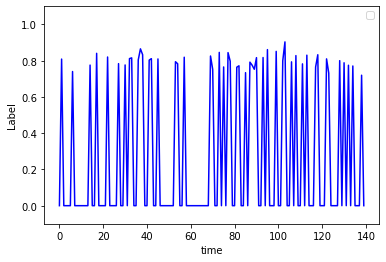

In [4]:
# test

file_name = '8_actions'
n_sec = 140   # enter the length of video (sec)
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (52, 75)
y_hat shape = (52, 1)
18
{'pick up': [[0, 0.8861794425890996], [1, 0.8928882479667664], [2, 0.9074667096138]]}


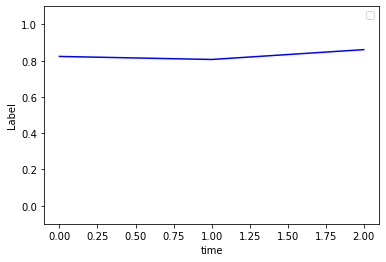

In [10]:
# test1

file_name = 'pick37'
n_sec = 3
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
29
{'pick up': [0, 0.2856084704399109]}


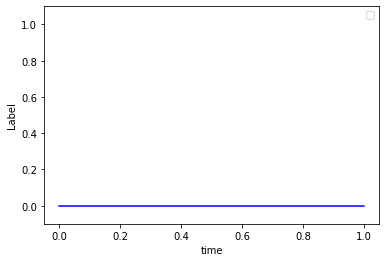

In [9]:
# test2

file_name = 'wave36'
n_sec = 2
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
25
{'pick up': [[0, 0.8931205456073468], [1, 0.9027007222175598]]}


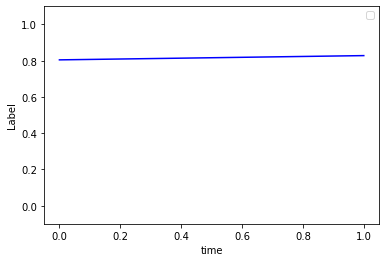

In [8]:
# test3

file_name = 'pick38'
n_sec = 2
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
19
{'pick up': [0, 0.15993213653564453]}


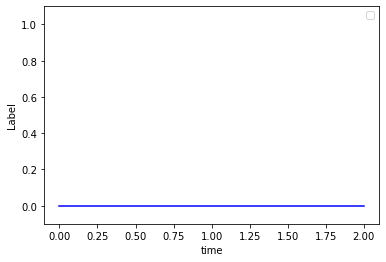

In [7]:
# test4

file_name = 'wave37'
n_sec = 3
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
25
{'pick up': [[0, 0.8813172847032547], [1, 0.8838635683059692]]}


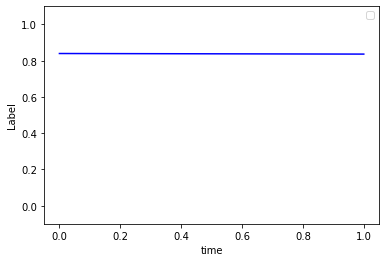

In [6]:
# test5

file_name = 'pick39'
n_sec = 2
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (305, 75)
y_hat shape = (305, 1)
24
{'pick up': [[0, 0.8208700087335374], [1, 0.8533695638179779], [2, 0.9200790013585772], [7, 0.8694588797433036], [9, 0.8792430087924004], [10, 0.8796533942222595], [11, 0.8817434642050002]]}


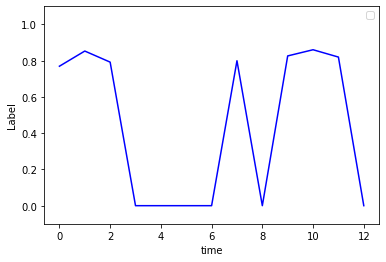

In [5]:
# test 6

file_name = 'test2'
n_sec = 13
j_dict = testing(file_name, n_sec)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)